# Denoise global seismic waveforms

Separate earthquake signals and noises on teleseismic waveform recordings using a two-branch U-net trained with global teleseismic data. The Denoiser uses the pretrained kernel WaveDecompNet(Yin et al 2022) to learn high-level features.

In [ ]:
!pip3 install h5py
!pip3 install torch -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install scipy
!pip3 install obspy
!pip3 install scikit-learn
!pip3 install pandas
!pip3 install multitaper
!pip3 install wget
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import modules

In [ ]:
import os
import h5py
import math
import time
import wget
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from numpy.random import default_rng
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

## Auto-encoder architecture (U-net)

We use a pre-trained simpler model as the kernel of the T-model class

In [ ]:
class T_model(nn.Module):
    def __init__(self, model):
        super(T_model, self).__init__()

        self.enc1 = nn.Conv1d(3, 8, 45, stride=1, padding='same', dtype=torch.float64)
        self.bn1 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.enc2 = nn.Conv1d(8, 8, 21, stride=2, padding=10, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.enc3 = nn.Conv1d(8, 8, 21, stride=2, padding=10, dtype=torch.float64)
        self.bn3 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.enc4 = nn.Conv1d(8, 8, 21, stride=2, padding=10, dtype=torch.float64)
        self.bn4 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.enc5 = nn.Conv1d(8, 3, 9, stride=1, padding='same', dtype=torch.float64)
        self.bn5 = nn.BatchNorm1d(3, dtype=torch.float64)
        self.fc6 = nn.Linear(750, 600, dtype=torch.float64)
        self.bn6 = nn.BatchNorm1d(3, dtype=torch.float64)

        self.model = model

        self.fc61 = nn.Linear(600, 750, dtype=torch.float64)
        self.fc62 = nn.Linear(600, 750, dtype=torch.float64)
        self.bn61 = nn.BatchNorm1d(3, dtype=torch.float64)
        self.bn62 = nn.BatchNorm1d(3, dtype=torch.float64)
        self.dec51 = nn.ConvTranspose1d(3, 8, 9, stride=1, padding=4, output_padding=0, dtype=torch.float64)
        self.dec52 = nn.ConvTranspose1d(3, 8, 9, stride=1, padding=4, output_padding=0, dtype=torch.float64)
        self.bn51 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.bn52 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.dec41 = nn.ConvTranspose1d(8, 8, 21, stride=2, padding=10, output_padding=1, dtype=torch.float64)
        self.dec42 = nn.ConvTranspose1d(8, 8, 21, stride=2, padding=10, output_padding=1, dtype=torch.float64)
        self.bn41 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.bn42 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.dec31 = nn.ConvTranspose1d(8, 8, 21, stride=2, padding=10, output_padding=1, dtype=torch.float64)
        self.dec32 = nn.ConvTranspose1d(8, 8, 21, stride=2, padding=10, output_padding=1, dtype=torch.float64)
        self.bn31 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.bn32 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.dec21 = nn.ConvTranspose1d(8, 8, 21, stride=2, padding=10, output_padding=1, dtype=torch.float64)
        self.dec22 = nn.ConvTranspose1d(8, 8, 21, stride=2, padding=10, output_padding=1, dtype=torch.float64)
        self.bn21 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.bn22 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.dec11 = nn.ConvTranspose1d(8, 3, 45, stride=1, padding=22, output_padding=0, dtype=torch.float64)
        self.dec12 = nn.ConvTranspose1d(8, 3, 45, stride=1, padding=22, output_padding=0, dtype=torch.float64)
        self.bn11 = nn.BatchNorm1d(3, dtype=torch.float64)
        self.bn12 = nn.BatchNorm1d(3, dtype=torch.float64)

    def forward(self, x):
        x = F.relu(self.bn1(self.enc1(x)))
        #x = F.relu(self.bn2(self.enc2(x)))
        x0= self.enc3(x)
        x = F.relu(self.bn3(x0))
        #x = F.relu(self.bn4(self.enc4(x)))
        x1= self.enc5(x)
        x = F.relu(self.bn5(x1))
        x = F.relu(self.bn6(self.fc6(x)))

        y = self.model(x)
        y1 = y[0]
        y2 = y[1]

        y1 = self.bn61(self.fc61(F.relu(y1)))
        y2 = self.bn62(self.fc62(F.relu(y2)))
        y1 = self.bn51(self.dec51(F.relu(y1)) + x0)
        y2 = self.bn52(self.dec52(F.relu(y2)) + x0)
        # y1 = self.bn41(self.dec41(F.relu(y1)))
        # y2 = self.bn42(self.dec42(F.relu(y2)))
        y1 = self.bn31(self.dec31(F.relu(y1)))
        y2 = self.bn32(self.dec32(F.relu(y2)))
        # y1 = self.bn21(self.dec21(F.relu(y1)))
        # y2 = self.bn22(self.dec22(F.relu(y2)))
        y1 = self.bn11(self.dec11(F.relu(y1)))
        y2 = self.bn12(self.dec12(F.relu(y2)))

        return y1, y2

### Data class for pytorch

In [ ]:
# covert the numpy array to torch tensor for ML
class WaveformDataset(Dataset):
    def __init__(self, X_train, Y_train):
        self.X_train = np.moveaxis(X_train, 1, -1)
        self.Y_train = np.moveaxis(Y_train, 1, -1)

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        X_waveform = self.X_train[idx]
        Y_waveform = self.Y_train[idx]
        return X_waveform, Y_waveform

### New loss function

In [ ]:
# New loss function combining mean-squared-error and waveform cross-coreelation
class CCMSELoss(torch.nn.Module):
    def __init__(self, use_weight=False):
        super().__init__()
        self.use_weight = use_weight

    def forward(self, x, y, weight=1):
        cc = torch.sum(torch.mul(x, y), dim=2)
        n1 = torch.sum(torch.square(x), dim=2)
        n2 = torch.sum(torch.square(y), dim=2)
        cc = cc / torch.sqrt(n1 * n2)

        mse = torch.mean(torch.square(x - y), dim=2)

        if self.use_weight:
            cc = torch.nanmean(cc, dim=1)
            mse = torch.nanmean(mse, dim=1)
            ccmseloss = torch.nanmean(mse/weight) + 1 - torch.nanmean(cc)
        else:
            ccmseloss = torch.nanmean(mse) + 1 - torch.nanmean(cc)

        return ccmseloss

### Early stopping scheme for training

In [ ]:
# from https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Training function

In [ ]:
# Training scheme, with data augmentation on the fly
def training_loop_branches_augmentation(train_dataloader, validate_dataloader, model, loss_fn, optimizer, epochs,
                                            patience, device, minimum_epochs=None, npts=3000, mid_pt=25000, strmax=6):
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    avg_train_losses1 = []  # earthquake average loss with epoch
    avg_train_losses2 = []  # noise average loss with epoch

    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    avg_valid_losses1 = []  # earthquake average loss with epoch
    avg_valid_losses2 = []  # noise average loss with epoch

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, epochs + 1):
        # estimate time for each epoch
        starttime = time.time()

        # to track the training loss as the model trains
        train_losses = []
        train_losses1 = []  # earthquake loss
        train_losses2 = []  # noise loss

        # to track the validation loss as the model trains
        valid_losses = []
        valid_losses1 = []  # earthquake loss
        valid_losses2 = []  # noise loss

        # ======================= training =======================
        # initialize the model for training
        model.train()
        size = len(train_dataloader.dataset)
        for batch, (X0, y0) in enumerate(train_dataloader):
            # stack and shift
            nbatch = X0.size(0)
            std_wgt = torch.ones(nbatch, dtype=torch.float64)
            quak2 = torch.zeros(nbatch, y0.size(1), npts * 2, dtype=torch.float64)
            quake = torch.zeros(y0.size(), dtype=torch.float64)
            stack = torch.zeros(y0.size(), dtype=torch.float64)
            rng = default_rng(batch * epoch)
            rng_snr = default_rng(batch * epoch + 1)
            rng_sqz = default_rng(batch * epoch + 2)
            start_pt = rng.choice(npts - int(npts * 0.2), nbatch) + int(npts * 0.1)
            snr = 10 ** rng_snr.uniform(-0.3, 1, nbatch)
            sqz = rng_sqz.choice(int(strmax), nbatch) + 1
            pt1 = mid_pt - sqz * npts
            pt2 = mid_pt + sqz * npts

            for i in np.arange(nbatch):
                # %% squeeze earthquake signal
                quak2[i] = X0[i, :, pt1[i]:pt2[i]:sqz[i]]
                # %% shift earthquake signal
                tmp = quak2[i, :, start_pt[i]:start_pt[i] + npts]
                for j in np.arange(X0.size(1)):
                    quake[i, j] = torch.div(torch.sub(tmp[j], torch.mean(tmp[j], dim=-1)),
                                            torch.std(tmp[j], dim=-1) + 1e-12) * snr[i]
                # %% stack signal and noise
                stack[i] = quake[i] + y0[i]
                # %% normalize
                scale_mean = torch.mean(stack[i], dim=1)
                scale_std = torch.std(stack[i], dim=1) + 1e-12
                std_wgt[i] = torch.nanmean(scale_std)
                for j in np.arange(X0.size(1)):
                    stack[i, j] = torch.div(torch.sub(stack[i, j], scale_mean[j]), scale_std[j])
                    quake[i, j] = torch.div(torch.sub(quake[i, j], scale_mean[j]), scale_std[j])

            X, y = stack.to(device), quake.to(device)
            snr = torch.from_numpy(snr).to(device)
            std_wgt = std_wgt.to(device)

            # Compute prediction and loss
            pred1, pred2 = model(X)
            loss1 = loss_fn(pred1, y, snr**2)
            loss2 = loss_fn(pred2, X - y)
            loss3 = loss_fn(pred1 + pred2, X, std_wgt**2)

            loss = loss1 + loss2 + loss3

            # record training loss
            train_losses.append(loss.item())
            train_losses1.append(loss1.item())
            train_losses2.append(loss2.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ======================= validating =======================
        # initialize the model for training
        model.eval()
        with torch.no_grad():
            for X0, y0 in validate_dataloader:
                # stack and shift
                nbatch = X0.size(0)
                std_wgt = torch.ones(nbatch, dtype=torch.float64)
                quak2 = torch.zeros(nbatch, y0.size(1), npts * 2, dtype=torch.float64)
                quake = torch.zeros(y0.size(), dtype=torch.float64)
                stack = torch.zeros(y0.size(), dtype=torch.float64)
                rng = default_rng(batch * epoch)
                rng_snr = default_rng(batch * epoch + 1)
                rng_sqz = default_rng(batch * epoch + 2)
                start_pt = rng.choice(npts - int(npts * 0.2), nbatch) + int(npts * 0.1)
                snr = 10 ** rng_snr.uniform(-0.3, 1, nbatch)
                sqz = rng_sqz.choice(int(strmax), nbatch) + 1
                pt1 = mid_pt - sqz * npts
                pt2 = mid_pt + sqz * npts

                for i in np.arange(nbatch):
                    # %% squeeze earthquake signal
                    quak2[i] = X0[i, :, pt1[i]:pt2[i]:sqz[i]]
                    # %% shift earthquake signal
                    tmp = quak2[i, :, start_pt[i]:start_pt[i] + npts]
                    for j in np.arange(X0.size(1)):
                        quake[i, j] = torch.div(torch.sub(tmp[j], torch.mean(tmp[j], dim=-1)),
                                                torch.std(tmp[j], dim=-1) + 1e-12) * snr[i]
                    # %% stack signal and noise
                    stack[i] = quake[i] + y0[i]
                    # %% normalize
                    scale_mean = torch.mean(stack[i], dim=1)
                    scale_std = torch.std(stack[i], dim=1) + 1e-12
                    std_wgt[i] = torch.nanmean(scale_std)
                    for j in np.arange(X0.size(1)):
                        stack[i, j] = torch.div(torch.sub(stack[i, j], scale_mean[j]), scale_std[j])
                        quake[i, j] = torch.div(torch.sub(quake[i, j], scale_mean[j]), scale_std[j])

                X, y = stack.to(device), quake.to(device)
                snr = torch.from_numpy(snr).to(device)
                std_wgt = std_wgt.to(device)

                pred1, pred2 = model(X)
                loss1 = loss_fn(pred1, y, snr**2)
                loss2 = loss_fn(pred2, X - y)
                loss3 = loss_fn(pred1 + pred2, X, std_wgt**2)

                loss = loss1 + loss2 + loss3

                # record validation loss
                valid_losses.append(loss.item())
                valid_losses1.append(loss1.item())
                valid_losses2.append(loss2.item())

        # calculate average loss over an epoch
        # total loss
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # earthquake waveform loss
        train_loss1 = np.average(train_losses1)
        valid_loss1 = np.average(valid_losses1)
        avg_train_losses1.append(train_loss1)
        avg_valid_losses1.append(valid_loss1)

        # ambient noise waveform loss
        train_loss2 = np.average(train_losses2)
        valid_loss2 = np.average(valid_losses2)
        avg_train_losses2.append(train_loss2)
        avg_valid_losses2.append(valid_loss2)

        # print training/validation statistics
        epoch_len = len(str(epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}\n' +
                     f'time per epoch: {(time.time() - starttime):.3f} s')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        if (minimum_epochs is None) or ((minimum_epochs is not None) and (epoch > minimum_epochs)):
            # early_stopping needs the validation loss to check if it has decresed,
            # and if it has, it will make a checkpoint of the current model
            early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    partial_loss = [avg_train_losses1, avg_valid_losses1, avg_train_losses2, avg_valid_losses2]

    return model, avg_train_losses, avg_valid_losses, partial_loss


_______________________
_______________________











## Download seismic data and pre-trained kernel

The data is aranged in arrays of 3-component seismograms. The labels are "earthquakes" and "noise", the data is sampled at 10Hz. 

In [ ]:
wget.download("https://www.dropbox.com/s/jxg19pqj36deomv/chunk500.hdf5?dl=1")
# use shell command to download *py properly
!wget --no-cache --backups=1 {"https://raw.githubusercontent.com/qibinshi/TeleseismicDenoiser/main/example/Model_and_datasets_1D_all_snr_40/Branch_Encoder_Decoder_LSTM/Branch_Encoder_Decoder_LSTM_Model.pth"}
!wget --no-cache --backups=1 {"https://raw.githubusercontent.com/qibinshi/TeleseismicDenoiser/main/src/denoise/autoencoder_1D_models_torch.py"}

--2022-12-02 19:17:20--  https://raw.githubusercontent.com/qibinshi/TeleseismicDenoiser/main/example/Model_and_datasets_1D_all_snr_40/Branch_Encoder_Decoder_LSTM/Branch_Encoder_Decoder_LSTM_Model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1499003 (1.4M) [application/octet-stream]
Saving to: ‘Branch_Encoder_Decoder_LSTM_Model.pth’

Branch_Encoder_Deco 100%[===================>]   1.43M  --.-KB/s    in 0.04s   

2022-12-02 19:17:20 (33.0 MB/s) - ‘Branch_Encoder_Decoder_LSTM_Model.pth’ saved [1499003/1499003]

--2022-12-02 19:17:21--  https://raw.githubusercontent.com/qibinshi/TeleseismicDenoiser/main/src/denoise/autoencoder_1D_models_torch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.1

## Read H5 file and create noisy dataset

We extract the window surrounding S-wave pulse and stretch to 150s. We stack 150s-long S waves with noises to create noisy dataset.

In [ ]:
model_dir = 'trained_model'
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
wave_raw = 'chunk500.hdf5'

frac = 0.1  # starting fraction not included in shifting window
npts = 1500 # number of points of the final waveform trace
strmax = 4  # maximum stretching ratio
mid_pt = 20000  # S wave pulse time in the raw data

weighted_loss = False
kernel_name = "Branch_Encoder_Decoder_LSTM_Model.pth"

In [ ]:
with h5py.File(wave_raw, 'r') as f:
  X_train = f['quake'][:]
  Y_train = f['noise'][:, (0 - npts):, :]

# remove zeros from the raw data
X_sum = np.sum(np.sum(np.square(X_train), axis=1), axis=1)
ind_X = np.where(X_sum == np.nan)[0]
X_train = np.delete(X_train, ind_X, 0)
Y_train = np.delete(Y_train, ind_X, 0)
print(len(X_train), len(Y_train), ind_X, X_sum.shape)

144 144 [] (144,)


In [ ]:
# normalize the data
X_train = (X_train - np.mean(X_train, axis=1, keepdims=True)) / (np.std(X_train, axis=1, keepdims=True) + 1e-12)
Y_train = (Y_train - np.mean(Y_train, axis=1, keepdims=True)) / (np.std(Y_train, axis=1, keepdims=True) + 1e-12)

In [ ]:
# split datasets into train, valid and test sets
train_size = 0.6  # 60%
test_size = 0.5  # (1-80%) x 50%
rand_seed1 = 43
rand_seed2 = 11
X_training, X_test, Y_training, Y_test = train_test_split(X_train, Y_train,
                                                          train_size=train_size,
                                                          random_state=rand_seed1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test,
                                                          test_size=test_size,
                                                          random_state=rand_seed2)

# Convert to torch class. Or WaveformDataset_h5 for limited memory
training_data = WaveformDataset(X_training, Y_training)
validate_data = WaveformDataset(X_validate, Y_validate)
test_data = WaveformDataset(X_test, Y_test)

# Fix seed for model initialization
random.seed(0)
np.random.seed(20)
torch.manual_seed(99)
torch.backends.cudnn.benchmark = False


## Build the model of autoencoder

We embed the pre-trained kernel into the structure of the T-model class

In [ ]:
# embed the kernel into the autoencoder
devc = torch.device('cpu')
model = torch.load(kernel_name, map_location=devc)
model = T_model(model)
model.to(devc)

n_para = 0
for idx, param in enumerate(model.parameters()):
  if not param.requires_grad:
    print(idx, param.shape)
  else:
    n_para += np.prod(param.shape)
print(f'Number of parameters to be trained: {n_para}\n')

Number of parameters to be trained: 1546859



## Start training

In [ ]:
# Hyper-parameters for training
batch_size, epochs, lr = 64, 100, 2e-3
minimum_epochs, patience = 30, 20  # patience for early stopping
loss_fn = CCMSELoss(use_weight=weighted_loss)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

# Use Dataloader with batch_size
train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=False)
validate_iter = DataLoader(validate_data, batch_size=batch_size, shuffle=False)
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=False)


## Training loop

In [ ]:
model, avg_train_losses, avg_valid_losses, partial_loss = training_loop_branches_augmentation(train_iter,
                                                                                              validate_iter,
                                                                                              model,
                                                                                              loss_fn,
                                                                                              optimizer,
                                                                                              epochs=epochs,
                                                                                            patience=patience,
                                                                                              device=devc,
                                                                                      minimum_epochs=minimum_epochs,
                                                                                                npts=npts,
                                                                                              mid_pt=mid_pt,
                                                                                              strmax=strmax)

print("Training is done!")

# Save the model
torch.save(model, model_dir + f'/{kernel_name}_Model.pth')

# Save the training history
loss = avg_train_losses
val_loss = avg_valid_losses
with h5py.File(model_dir + f'/{kernel_name}_Training_history.hdf5', 'w') as f:
  f.create_dataset("loss", data=loss)
  f.create_dataset("val_loss", data=val_loss)
  f.create_dataset("earthquake_loss", data=partial_loss[0])
  f.create_dataset("earthquake_val_loss", data=partial_loss[1])
  f.create_dataset("noise_loss", data=partial_loss[2])
  f.create_dataset("noise_val_loss", data=partial_loss[3])

# %% Save the training info
with h5py.File(model_dir + f'/{kernel_name}_Dataset_split.hdf5', 'w') as f:
  f.attrs['model_name'] = kernel_name
  f.attrs['train_size'] = train_size
  f.attrs['test_size'] = test_size
  f.attrs['rand_seed1'] = rand_seed1
  f.attrs['rand_seed2'] = rand_seed2

[  1/100] train_loss: 8.80205 valid_loss: 4.37200
time per epoch: 3.063 s
[  2/100] train_loss: 6.29785 valid_loss: 3.97055
time per epoch: 3.220 s
[  3/100] train_loss: 5.32589 valid_loss: 3.62399
time per epoch: 3.158 s
[  4/100] train_loss: 4.93395 valid_loss: 3.58310
time per epoch: 6.185 s
[  5/100] train_loss: 4.59941 valid_loss: 3.69895
time per epoch: 6.445 s
[  6/100] train_loss: 4.40925 valid_loss: 3.95699
time per epoch: 4.243 s
[  7/100] train_loss: 4.33834 valid_loss: 4.52736
time per epoch: 3.179 s
[  8/100] train_loss: 4.26341 valid_loss: 4.71070
time per epoch: 3.041 s
[  9/100] train_loss: 4.10668 valid_loss: 4.84714
time per epoch: 3.226 s
[ 10/100] train_loss: 4.03020 valid_loss: 4.88051
time per epoch: 3.091 s
[ 11/100] train_loss: 3.90423 valid_loss: 4.68708
time per epoch: 3.101 s
[ 12/100] train_loss: 3.78967 valid_loss: 4.19478
time per epoch: 3.415 s
[ 13/100] train_loss: 3.60331 valid_loss: 3.92432
time per epoch: 3.229 s
[ 14/100] train_loss: 3.50148 valid_lo

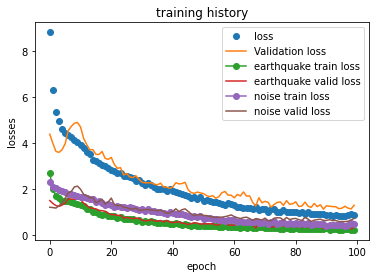

In [ ]:

## Plot training and validation losses
plt.close('all')
plt.figure()
plt.plot(loss, 'o', label='loss')
plt.plot(val_loss, '-', label='Validation loss')
loss_name_list = ['earthquake train loss', 'earthquake valid loss', 'noise train loss', 'noise valid loss']
loss_plot_list = ['o', '', 'o', '']
for ii in range(4):
    plt.plot(partial_loss[ii], marker=loss_plot_list[ii], label=loss_name_list[ii])

plt.legend()
plt.xlabel("epoch")
plt.ylabel("losses")
plt.title("training history")
plt.show()

## Test the model

In [ ]:
# apply the model to denoise the test data
with torch.no_grad():
    data_iter = iter(test_iter)
    X0, y0 = data_iter.next()

    # %% Augmentation: 1-squeeze 2-shift 3-stack
    nbatch = X0.size(0)
    rng = default_rng(17)
    rng_snr = default_rng(23)
    rng_sqz = default_rng(11)
    start_pt = rng.choice(npts - int(npts * frac * 2), nbatch) + int(npts * frac)
    snr = 10 ** rng_snr.uniform(-0.3, 0.5, nbatch)
    sqz = rng_sqz.choice(strmax, nbatch) + 1
    pt1 = mid_pt - sqz * npts
    pt2 = mid_pt + sqz * npts

    quak2 = torch.zeros(nbatch, y0.size(1), npts * 2, dtype=torch.float64)
    quake = torch.zeros(y0.size(), dtype=torch.float64)
    stack = torch.zeros(y0.size(), dtype=torch.float64)

    for i in np.arange(nbatch):
        # %% squeeze earthquake signal
        print(pt1[i],pt2[i],sqz[i])

        quak2[i] = X0[i, :, pt1[i]:pt2[i]:sqz[i]]
        # %% shift earthquake signal
        tmp = quak2[i, :, start_pt[i]:start_pt[i] + npts]
        for j in np.arange(X0.size(1)):
            quake[i, j] = torch.div(torch.sub(tmp[j], torch.mean(tmp[j], dim=-1)),
                                    torch.std(tmp[j], dim=-1) + 1e-12) * snr[i]
        # %% stack signal and noise
        stack[i] = quake[i] + y0[i]
        # %% normalize
        scale_mean = torch.mean(stack[i], dim=1)
        scale_std = torch.std(stack[i], dim=1) + 1e-12
        for j in np.arange(X0.size(1)):
            stack[i, j] = torch.div(torch.sub(stack[i, j], scale_mean[j]), scale_std[j])
            quake[i, j] = torch.div(torch.sub(quake[i, j], scale_mean[j]), scale_std[j])

    noisy_input, quake_label = stack.to(devc), quake.to(devc)
    noise_label = noisy_input - quake_label

    quake_denoised, noise_output = model(noisy_input)

    noisy_signal = noisy_input.numpy()
    clean_signal = quake_label.numpy()
    separated_noise = noise_output.numpy()
    denoised_signal = quake_denoised.numpy()
    true_noise = noise_label.numpy()


18500 21500 1
18500 21500 1
14000 26000 4
17000 23000 2
15500 24500 3
15500 24500 3
15500 24500 3
18500 21500 1
17000 23000 2
18500 21500 1
17000 23000 2
14000 26000 4
15500 24500 3
18500 21500 1
15500 24500 3
18500 21500 1
14000 26000 4
14000 26000 4
14000 26000 4
15500 24500 3
14000 26000 4
17000 23000 2
18500 21500 1
15500 24500 3
17000 23000 2
15500 24500 3
14000 26000 4
17000 23000 2
14000 26000 4


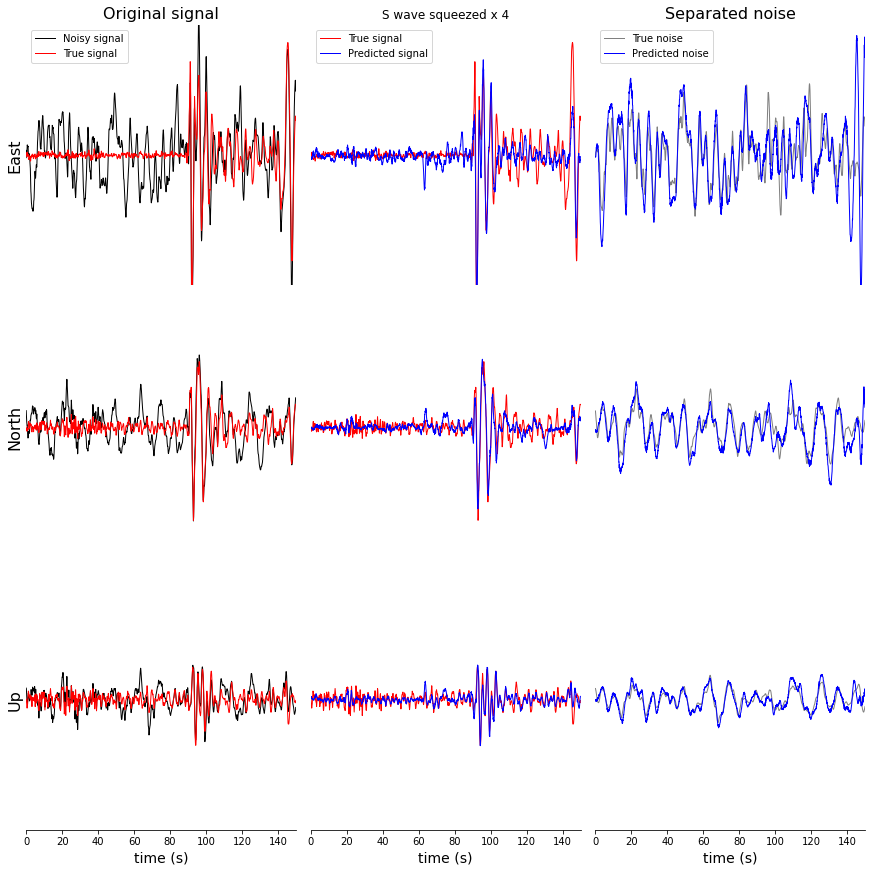

In [ ]:
# Plot example waveforms
trace_num = 11 # Use arbitrary trace number to plot

plt.close("all")
time = np.arange(0, npts) * 0.1
gs_kw = dict(height_ratios=[1, 1, 1])
comps = ['East','North','Up']
fig, ax = plt.subplots(3, 3, gridspec_kw=gs_kw, figsize=(12, 12), constrained_layout=True)

for i in range(3):
    scaling_factor = np.max(abs(noisy_signal[i, :]))
    ax[i, 0].plot(time, noisy_signal[trace_num, i, :] / scaling_factor, '-k', label='Noisy signal', linewidth=1)
    ax[i, 0].plot(time, clean_signal[trace_num, i, :] / scaling_factor, '-r', label='True signal', linewidth=1)
    ax[i, 1].plot(time, clean_signal[trace_num, i, :] / scaling_factor, '-r', label='True signal', linewidth=1)
    ax[i, 1].plot(time, denoised_signal[trace_num, i, :] / scaling_factor, '-b', label='Predicted signal', linewidth=1)
    ax[i, 2].plot(time, true_noise[trace_num, i, :] / scaling_factor, '-', color='gray', label='True noise', linewidth=1)
    ax[i, 2].plot(time, separated_noise[trace_num, i, :] / scaling_factor, '-b', label='Predicted noise', linewidth=1)

    ax[i, 0].set_ylabel(comps[i], fontsize=16)

    for j in range(3):
        ax[i, j].xaxis.set_visible(False)
        ax[i, j].yaxis.set_ticks([])
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)

        if i == 2:
            ax[i, j].xaxis.set_visible(True)
            ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].set_xlabel('time (s)', fontsize=14)
        if i <= 2:
            ax[i, j].set_xlim(0, npts * 0.1)
            ax[i, j].set_ylim(-1, 1)

    ax[0, 0].legend(loc=0)
    ax[0, 1].legend(loc=0)
    ax[0, 2].legend(loc=0)
ax[0, 0].set_title("Original signal", fontsize=16)
ax[0, 1].set_title(f"S wave squeezed x {sqz[trace_num]}")
ax[0, 2].set_title("Separated noise", fontsize=16)
plt.show()